In [2]:
# 批量归一化
# 损失出现在最后，后面的层训练比较快
# 数据在底部训练的比较慢
# 底部数据一变化上面一起变
# 最后那些层多次重新学习
# 收敛变慢


In [1]:
# 批量归一化
# 固定小批量里面的均值和方差
# 然后再做额外的调整
# 类似于标准化
# 批量归一化层
# --全连接层和卷积层输出上，激活函数前
# --全连接层和卷积层输入上
# 对于全连接层，作用在特征维(标量的处理)
# (与 layer normalization 不同)
# 对于卷积层，作用在通道维 
# 每个像素就是一个样本(通道维就是特征维) 
# 本意是来减少内部协变量 
# 后来发现不是这个作用(实际上是噪音控制模型复杂度)

# 固定出小批量的均值和方差，然后学习出合适的偏移和缩放
# 加快收敛速度，但一般不改变模型精度


In [3]:
import torch 
from torch import nn 
from d2l import torch as d2l 

In [4]:
# 推理时用的全局的均值和方差
# batchnorm 函数
def batch_norm(X,gamma,beta,moving_mean,moving_var,eps,momentum):
    if not torch.is_grad_enabled():
        X_hat=(X-moving_mean)/torch.sqrt(moving_var+eps)
    else: 
        assert len(X.shape) in (2,4)
        if len(X.shape)==2:
            mean=X.mean(dim=0)
            var=((X-mean)**2).mean(dim=0)
        else: 
            mean=X.mean(dim=(0,2,3),keepdim=True)
            var=((X-mean)**2).mean(dim=(0,2,3),keepdim=True)
        X_hat=((X-mean))/torch.sqrt(var+eps)
        moving_mean=momentum*moving_mean+(1.0-momentum)*mean
        moving_var=momentum*moving_var+(1.0-momentum)*var
    Y=gamma*X_hat+beta
    return Y,moving_mean.data,moving_var.data

In [10]:
# BatchNorm 图层
class BatchNorm(nn.Module):
    def __init__(self,num_features,num_dims):
        super().__init__()
        if num_dims==2:
            shape=(1,num_features)
        else:
            shape=(1,num_features,1,1)
        
        self.gamma=nn.Parameter(torch.ones(shape))
        self.beta=nn.Parameter(torch.zeros(shape))
        self.moving_mean=torch.zeros(shape)
        self.moving_var=torch.ones(shape)
    
    def forward(self,X):
        if self.moving_mean.device!=X.device:
            self.moving_mean=self.moving_mean.to(X.device)
            self.moving_var=self.moving_var.to(X.device)
        Y,self.moving_mean,self.moving_var=batch_norm(
            X,self.gamma,self.beta,self.moving_mean,self.moving_var,
            eps=1e-5,momentum=0.9
        )
        return Y

In [11]:
net = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5), 
        BatchNorm(6, num_dims=4),
        nn.Sigmoid(), 
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16,
            kernel_size=5), 
        BatchNorm(16, num_dims=4),
        nn.Sigmoid(), 
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(), 
        nn.Linear(16 * 4 * 4, 120),
        BatchNorm(120, num_dims=2), 
        nn.Sigmoid(),
        nn.Linear(120, 84), 
        BatchNorm(84, num_dims=2),
        nn.Sigmoid(), 
        nn.Linear(84, 10)
    )


loss 0.250, train acc 0.908, test acc 0.881
40542.2 examples/sec on cuda:0


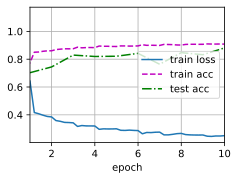

In [12]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())


loss 0.243, train acc 0.910, test acc 0.854
39695.5 examples/sec on cuda:0


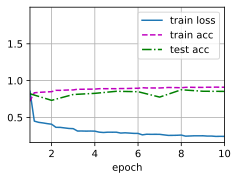

In [13]:
lr, num_epochs, batch_size = 2.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
# 精度一般 但是收敛变快了

In [15]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))


(tensor([2.8786, 1.1513, 2.0747, 1.6051, 1.6800, 4.6842], device='cuda:0',
        grad_fn=<ViewBackward>),
 tensor([-3.0149, -1.3115, -0.5682, -0.7761, -2.3374,  3.8119], device='cuda:0',
        grad_fn=<ViewBackward>))

In [16]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(256, 120), nn.BatchNorm1d(120),
                    nn.Sigmoid(), nn.Linear(120, 84), nn.BatchNorm1d(84),
                    nn.Sigmoid(), nn.Linear(84, 10))


loss 0.267, train acc 0.901, test acc 0.825
60744.0 examples/sec on cuda:0


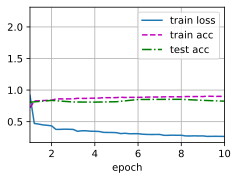

In [17]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())


In [18]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6,momentum=0.9),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16,momentum=0.9),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(256, 120), nn.BatchNorm1d(120,momentum=0.9),
                    nn.Sigmoid(), nn.Linear(120, 84), nn.BatchNorm1d(84,momentum=0.9),
                    nn.Sigmoid(), nn.Linear(84, 10))


loss 0.260, train acc 0.902, test acc 0.807
59561.1 examples/sec on cuda:0


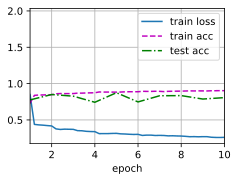

In [19]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [21]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), 
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), 
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(256, 120), 
                    nn.Sigmoid(), nn.Linear(120, 84), 
                    nn.Sigmoid(), nn.Linear(84, 10))


loss 0.442, train acc 0.832, test acc 0.822
74798.5 examples/sec on cuda:0


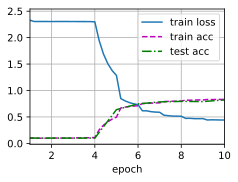

In [22]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())


loss 0.404, train acc 0.851, test acc 0.800
68972.0 examples/sec on cuda:0


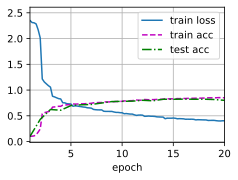

In [25]:
d2l.train_ch6(net, train_iter, test_iter, 20, lr=0.5,device= d2l.try_gpu())


loss 0.283, train acc 0.895, test acc 0.882
69408.8 examples/sec on cuda:0


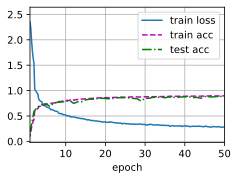

In [26]:
d2l.train_ch6(net, train_iter, test_iter, 50, lr=0.5, device=d2l.try_gpu())


In [27]:
# 模型稳定 收敛速度快 反正极端数据
# 主要用于深度神经网络 浅层没啥用
# BN加入噪音 使数值稳定 不容易出现极限情况 
# 一般线性层不一定能学到(先验知识)
# LayerNorm(样本里做Norm) 
# BatchNorm(跨样本做Norm)
# batch size 考虑每秒处理的样本数
# batch size 过大 收敛有问题